In [0]:
import fastai
from fastai import *
from fastai.vision import *

##  Download places365 resnet50 caffe model

In [0]:
! wget http://places2.csail.mit.edu/models_places365/vgg16_places365.caffemodel

--2019-03-30 14:34:45--  http://places2.csail.mit.edu/models_places365/vgg16_places365.caffemodel
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.100.255
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.100.255|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 543027219 (518M)
Saving to: ‘vgg16_places365.caffemodel’

vgg16_places365.caf 100%[===================>] 517.87M  27.7MB/s    in 18s     

2019-03-30 14:35:03 (28.8 MB/s) - ‘vgg16_places365.caffemodel’ saved [543027219/543027219]



## Training vgg16 on places365 pretrained weights

In [0]:
from torchvision.models import vgg16

In [0]:
vgg16_weights = torch.load('vgg16_places365.caffemodel.pth')

In [0]:
image_path = 'train/'
image_folder = 'train/'
train_csv = 'train.csv'
test_image_folder = 'test/'
test_csv = 'test_WyRytb0.csv'

In [0]:
vgg16_weights['fc8.weight'] = vgg16_weights.pop('fc8a.weight')
vgg16_weights['fc8.bias'] = vgg16_weights.pop('fc8a.bias')

In [0]:
model = vgg16()
model.features = torch.nn.Sequential(collections.OrderedDict(zip(['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'pool5'], model.features)))
model.classifier = torch.nn.Sequential(collections.OrderedDict(zip(['fc6', 'relu6', 'drop6', 'fc7', 'relu7', 'drop7', 'fc8'], model.classifier)))
model.classifier.fc8 = torch.nn.Linear(4096, 365)

state_dict = vgg16_weights
model.load_state_dict({l : torch.from_numpy(np.array(v)).view_as(p) for k, v in state_dict.items() for l, p in model.named_parameters() if k in l})


In [0]:
def get_model(pretrained):
  return model

## Define Image generator

In [0]:
data = ImageDataBunch.from_csv(path=image_path, folder=image_folder, csv_labels=train_csv, label_col=1, bs=64, 
                               test= test_image_folder, ds_tfms=get_transforms(), size=224, num_workers=1).normalize(imagenet_stats)

learn = cnn_learner(data, get_model, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


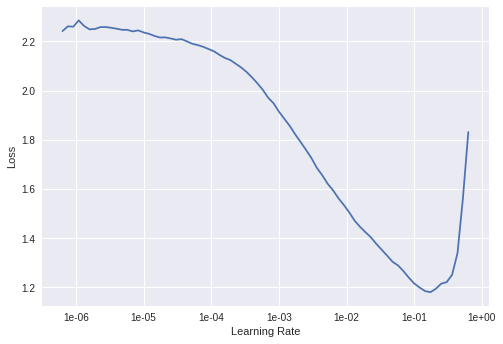

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.425956,0.293926,0.891955,02:43
1,0.348700,0.248260,0.910746,02:36
2,0.319410,0.244572,0.908103,02:37
3,0.276408,0.225395,0.921609,02:38
4,0.256590,0.222581,0.921022,02:37


In [0]:
learn.save('vgg16_365_freezed')

In [0]:
! cp train/models/vgg16_365_freezed.pth drive/My\ Drive/fastai_models/

## Load the previously trainedmodel

In [0]:
! cp drive/My\ Drive/fastai_models/vgg16_365_freezed.pth train/models/

In [0]:
learn.load('vgg16_365_freezed')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,5,0,4,1
Path: train;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,5,3,5,2
Path: train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_1): ReLU(inplace)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_2): ReLU(inplace)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2_1): Conv2d(64, 128, kernel_size=(3, 3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


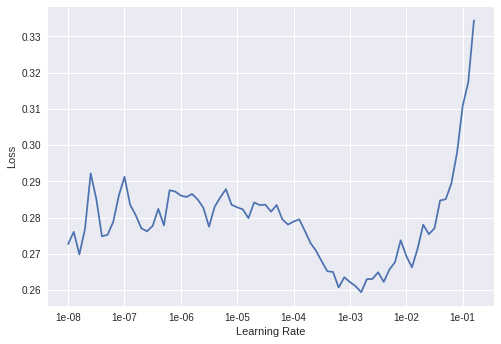

In [0]:
learn.lr_find(start_lr=1e-09)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.265461,0.197491,0.930710,03:24
1,0.266914,0.205612,0.928362,03:22
2,0.251344,0.203621,0.928655,03:22
3,0.237547,0.202699,0.929830,03:19
4,0.219744,0.199255,0.929536,03:21


## Frozen Predict

In [0]:
ds_type = DatasetType.Test
predictions = learn.get_preds(ds_type)

In [0]:
tta_predictions = learn.TTA(ds_type=DatasetType.Test)

In [0]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(tta_predictions[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_vgg16_places365_frozen_tta.csv', index=False)

In [0]:
learn.save('vgg16_365_frozen')

In [0]:
! cp train/models/vgg16_365_frozen.pth drive/My\ Drive/fastai_models/

## Unfreeze vgg16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


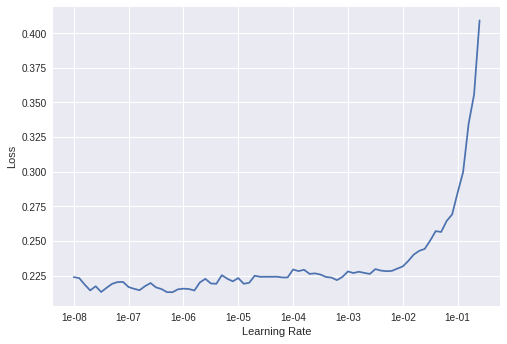

In [0]:
learn.lr_find(start_lr=1e-09)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, slice(1e-08, 1e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.232706,0.200547,0.928068,03:21
1,0.226713,0.200582,0.926894,03:17
2,0.219689,0.200585,0.930417,03:19


**For training data**

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)
losses, idx = train_interp.top_losses()
top_losses_path = data.train_ds.x[idx]

In [0]:
len(losses[losses > 2])

203

**For validation data**

In [0]:
valid_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
val_losses, valid_idx = valid_interp.top_losses()
top_val_losses_path = data.valid_ds.x[valid_idx]

In [0]:
len(val_losses[val_losses > 2])

80

In [0]:
vgg16_loss_paths = top_val_losses_path.items[:80].tolist()+ top_losses_path.items[:203].tolist()

In [0]:
with open('vgg16_loss_paths.txt', 'w') as f:
    for item in vgg16_loss_paths:
        f.write("%s\n" % item)

In [0]:
! cp vgg16_loss_paths.txt drive/My\ Drive/fastai_models/

In [0]:
delete_paths = []
for path in vgg16_loss_paths:
  delete_paths.append(re.sub('train/train//', '', path))

In [0]:
train_df = pd.read_csv('train/train.csv')
discarded_train = train_df.loc[~train_df.image_name.isin(delete_paths)]
train_df.shape, discarded_train.shape

((17034, 2), (16751, 2))

In [0]:
! rm train/train.csv
discarded_train.to_csv('train/train.csv', index=False)

## Retrain after deleting top loss images

**Mixup alpha=0.05**

In [0]:
data = ImageDataBunch.from_csv(path=image_path, folder=image_folder, csv_labels=train_csv, label_col=1, bs=64, 
                               test= test_image_folder, ds_tfms=get_transforms(), size=224, num_workers=1).normalize(imagenet_stats)

learn = cnn_learner(data, get_model, metrics=accuracy).mixup(alpha=0.05)

In [0]:
data

ImageDataBunch;

Train: LabelList (13401 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,4,1,5
Path: train;

Valid: LabelList (3350 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,5,4,4,2
Path: train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


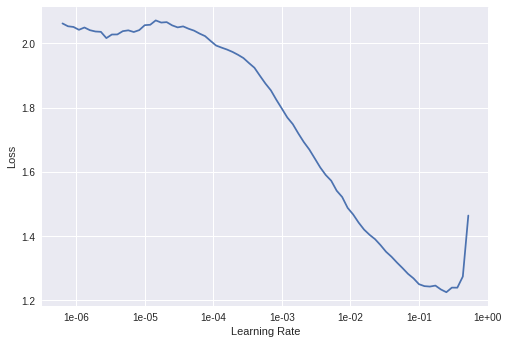

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.603297,0.277234,0.905075,03:19
1,0.521781,0.264591,0.908955,03:15
2,0.473500,0.235386,0.922985,03:16
3,0.442773,0.227533,0.928955,03:18
4,0.427979,0.226673,0.929851,03:16


In [0]:
ds_type = DatasetType.Test
predictions = learn.get_preds(ds_type)

In [0]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(predictions[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_vgg16_places365_top_loss_deleted_frozen_.csv', index=False)

**Mixup alpha=0.1**

In [0]:
data = ImageDataBunch.from_csv(path=image_path, folder=image_folder, csv_labels=train_csv, label_col=1, bs=64, 
                               test= test_image_folder, ds_tfms=get_transforms(), size=224, num_workers=1).normalize(imagenet_stats)

learn = cnn_learner(data, get_model, metrics=accuracy).mixup(alpha=0.1)

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.721939,0.283512,0.907164,03:16
1,0.626812,0.263692,0.912836,03:20
2,0.609676,0.253834,0.922388,03:19
3,0.579820,0.236924,0.931045,03:19
4,0.557754,0.227860,0.934925,03:18


In [0]:
ds_type = DatasetType.Test
predictions = learn.get_preds(ds_type)

In [0]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(predictions[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_vgg16_places365_top_loss_deleted_frozen_mixup_0.1.csv', index=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


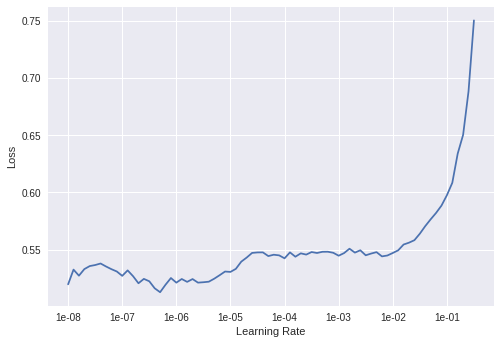

In [0]:
learn.lr_find(start_lr=1e-09)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(8e-08, 8e-07))

epoch,train_loss,valid_loss,accuracy,time
0,0.550381,0.233699,0.931045,03:16
1,0.539868,0.230068,0.932836,03:18
2,0.552777,0.226058,0.934925,03:17


In [0]:
tta_predictions = learn.TTA(ds_type=DatasetType.Test)

In [0]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(tta_predictions[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_vgg16_places365_top_loss_deleted_frozen_mixup_0.1_tta.csv', index=False)

**Mixup alpha=0.15**

In [0]:
data = ImageDataBunch.from_csv(path=image_path, folder=image_folder, csv_labels=train_csv, label_col=1, bs=64, 
                               test= test_image_folder, ds_tfms=get_transforms(), size=224, num_workers=1).normalize(imagenet_stats)

learn = cnn_learner(data, get_model, metrics=accuracy).mixup(alpha=0.15)

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.810314,0.308110,0.893731,03:13
1,0.702500,0.290650,0.909851,03:14
2,0.681972,0.268237,0.913731,03:14


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored